In [38]:
import os, sys, time, random, json, pickle, itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.neighbors import KernelDensity
import statsmodels.stats.correlation_tools as stm
random.seed(12345678)
np.random.seed(12345678)


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.random.seed(0)

In [40]:
import torch, torchvision
from sklearn.preprocessing import MinMaxScaler

In [28]:
# Define data files
datadir = 'dataverse_files/'
datafn_tmpl = datadir + 'sms-call-internet-mi-%4d-%02d-%02d.txt'
datafn_idxs = [ (2013, 11, i) for i in range(1, 31) ] # + [ (2013, 12, i) for i in range(1, 32) ] + [ (2014, 1, 1) ]
datafns = [ datafn_tmpl % x for x in datafn_idxs ]
print("Number of non-existent files:", sum([ not os.path.exists(fn) for fn in datafns ]))
outfn = datadir[:-1] + '-internet.csv'

Number of non-existent files: 0


In [41]:
# Pick the data files to index
fns = datafns#[:10]

In [30]:
# Read and Preprocess Data (Save to CSV)

In [31]:
data = pd.DataFrame()
for fn in fns:
    # print('Reading file ', fn, ' ...')
    df = pd.read_csv(fn, sep="\t", header=None, names=['grid', 'time', 'country', 'sms-in', 'sms-out', 'call-in', 'call-out', 'internet'])
    df = df[ df['country'] == 39 ].drop(columns=['country', 'sms-in', 'sms-out', 'call-in', 'call-out']).fillna(0)
    data = pd.concat([ data, df ])
data = data.sort_values(by=['time', 'grid']).reset_index(drop=True)

In [32]:
# Statistics of the dataset
print("# 10min slots:", len(data['time'].unique()) )
print("Mean internet:", data['internet'].mean())
print("(Min, 5%, 25%, median, 75%, 95%, max) internet:")
print( ( data['internet'].min(), data['internet'].quantile(0.05), data['internet'].quantile(0.25), data['internet'].median(), data['internet'].quantile(0.75), data['internet'].quantile(0.95), data['internet'].max() )  )

# 10min slots: 4320
Mean internet: 68.83680285080112
(Min, 5%, 25%, median, 75%, 95%, max) internet:
(0.0, 3.1688130042394684, 11.618447146635862, 29.181470293859828, 68.3242876275874, 269.6401681881977, 7936.265379884158)


In [33]:
data.to_csv(outfn)

In [39]:
# Load Data

In [40]:
data = pd.read_csv(outfn, index_col=0)
print("# 10min slots:", len(data['time'].unique()) )

# 10min slots: 720


In [41]:
# Find a grid with the maximum total demand for the prediction task
max_dmd_grid = sorted([ ( data[ data['grid']==i ]['internet'].sum(), i ) for i in range(1, 10001) ])
max_dmd_grid = list(reversed(max_dmd_grid))
gridx = max_dmd_grid[0][1]
max_dmd_grid[:30]

[(1104563.7452403838, 5161),
 (863319.3271304872, 5059),
 (733519.5353728977, 5061),
 (694052.1251055379, 5259),
 (644934.6993371418, 5758),
 (638665.6856640277, 5955),
 (635670.3048477777, 5258),
 (633964.1456596159, 6064),
 (616520.1902722106, 5262),
 (608361.6866170249, 4856),
 (598460.2357010082, 4855),
 (596631.9161060376, 5159),
 (590702.592801512, 5857),
 (571346.3977632335, 4459),
 (566481.8601180438, 4857),
 (561990.118845347, 5162),
 (552471.8502826013, 6058),
 (551190.9831383328, 6169),
 (547654.4822022254, 4755),
 (540140.8913652862, 5458),
 (537434.8978924416, 5567),
 (536868.8831254805, 4956),
 (510895.07771985105, 4961),
 (507620.7392957867, 4457),
 (503860.4929280743, 5256),
 (495886.1986362337, 6073),
 (485331.508461245, 5658),
 (485107.0936301125, 6072),
 (480841.7966404015, 6165),
 (477224.8672165216, 5855)]

In [42]:
datax = data[ data['grid'] == gridx ].reset_index(drop=True)

<AxesSubplot:>

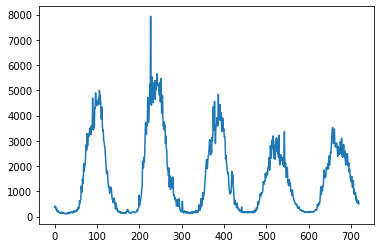

In [43]:
# Plot the data
datax['internet'].plot()

In [44]:
# Learning and Prediction

In [45]:
# Parameters
total_size = len(datax.index)

# Train/test split


test = np.empty([0, 0])
xvals = np.empty([0, 0])
yvals = np.empty([0, 0])

the_new_index = 0
i = 0
while i < int(total_size/3):
    xvals = np.append(xvals, the_new_index)
    yvals = np.append(yvals,datax['internet'][the_new_index])
    the_new_index += 3
    i += 1

train = yvals

for i in range(total_size):
    if np.isin(i, xvals) == False:
        test = np.append(test, datax['internet'][i])

m = len(yvals)

train_size = m
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)


Train size: 240 Test size: 480


In [46]:
print(xvals)

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.
 294. 297. 300. 303. 306. 309. 312. 315. 318. 321. 324. 327. 330. 333.
 336. 339. 342. 345. 348. 351. 354. 357. 360. 363. 366. 369. 372. 375.
 378. 381. 384. 387. 390. 393. 396. 399. 402. 405. 408. 411. 414. 417.
 420. 423. 426. 429. 432. 435. 438. 441. 444. 447. 450. 453. 456. 459.
 462. 465. 468. 471. 474. 477. 480. 483. 486. 489. 492. 495. 498. 501.
 504. 507. 510. 513. 516. 519. 522. 525. 528. 531. 534. 537. 540. 543.
 546. 549. 552. 555. 558. 561. 564. 567. 570. 573. 576. 579. 582. 585.
 588. 

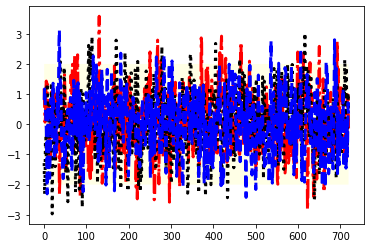

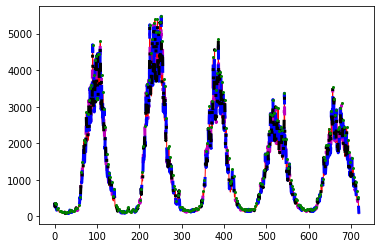

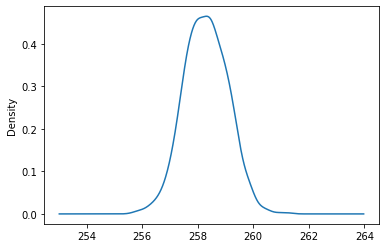

In [47]:
# sigma0 = 1e-14

xvals = np.reshape(xvals, (m, 1))
yvals = np.reshape(yvals, (m,1))

sigma0 = 10**(-20)

gamma = 2

ell = 1

xlim = total_size

# dx = 0.05

dx = 1

x =np.arange(0,xlim, dx) 

n = len(x)


# k = 144
k = len(yvals)

xp = 2

C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        C[i][j] = np.exp(-((x[i]-x[j])**gamma)/(2*(ell**2)))

C_ss = C
C = C + sigma0*np.eye(n,n)

# 
# Construct the matrices used for training and predictions
#


C_t = np.zeros((k,k))

for i in range(k):
    for j in range(k):
        C_t[i][j] = np.exp(-((xvals[i]-xvals[j])**gamma)/(2*(ell**2)))
        

C_tinv = np.linalg.inv(C_t)


C_s = np.zeros((k,n))

for i in range(k):
    for j in range(n):
        C_s[i][j] = np.exp(-((xvals[i]-x[j])**gamma)/(2*(ell**2)))

        
matrix_C_s_transpose_C_tinv = np.matmul(np.transpose(C_s),C_tinv)
mean = np.matmul(matrix_C_s_transpose_C_tinv,yvals);



C_cond = np.subtract(C_ss, np.matmul(matrix_C_s_transpose_C_tinv, C_s)) 

C_cond = np.add((np.add(C_cond, np.transpose(C_cond))/2), sigma0*np.eye(n,n))


for i in range(n):
    V= np.array([np.diagonal(C_cond)]).T
    
SD2 = 2*np.sqrt(abs(V))

c_s = np.zeros((k,1))

for i in range(k):
    c_s[i][0] = np.exp(-((xvals[i]-xp)**gamma)/(2*(ell**2)))

c_ss = 1

matrix_c_s_transpose_C_tinv = np.matmul(np.transpose(c_s),C_tinv)

c_cond = np.subtract(c_ss, np.matmul(matrix_c_s_transpose_C_tinv, c_s)) 

meanp = np.matmul(matrix_c_s_transpose_C_tinv, yvals)

#
# Compute the Cholesky decompositions C = R R^T where R is the lower triangular
#

# C = stm.cov_nearest(C)


def nearestPD(A):
   # """Find the nearest positive-definite matrix to input

    #A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    #credits [2].
    
   # [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    #[2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
   # matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False


# if __name__ == '__main__':
#     import numpy as np
#     for i in range(10):
#         for j in range(2, 100):
#             A = np.random.randn(j, j)
#             B = nearestPD(A)
#             assert (isPD(B))
#     print('unit test passed!')

if isPD(C) == False:
    C = nearestPD(C)

R = scipy.linalg.cholesky(C, lower=True)

# C_cond = stm.cov_nearest(C_cond)

if isPD(C_cond) == False:
    C_cond = nearestPD(C_cond)


R_cond = scipy.linalg.cholesky(C_cond, lower=True)

r_cond = np.sqrt(abs(c_cond))

#
# Sample n random variables z ~ N(0,1)
# and compute the prior functions f1, f2, f3
# and the posterior functions F1, F2, F3
#

f = np.zeros((n,3))
F = np.zeros((n,3))
g = np.zeros((1,1000))


for j in range(3):

    z = np.random.randn(n,1)
    for i in range(n):
        f[i][j] = np.matmul(R,z)[i]


for j in range(3):

    z = np.random.randn(n,1)
    for i in range(n):
        F[i][j] = np.add(mean[i], np.matmul(R_cond,z)[i])
                         
for j in range(1000):
    z = np.random.randn(1,1)
    g[0][j] = np.add(meanp, np.matmul(r_cond, z))

    
#
#plot the prior functions
#

y1 = -2*np.ones((n))
      
y2 = 2*np.ones((n))

x_concatenate_with_x_fliplr = np.array([x, np.flip(x)])
X = np.concatenate(x_concatenate_with_x_fliplr)


y1_concatenate_with_y2_fliplr = np.array([y1, np.flip(y2)])
Y = np.concatenate(y1_concatenate_with_y2_fliplr)

#
# GP Prior
#

plt.figure()
plt.fill(X, Y, matplotlib.colors.to_hex("#ffffe6"))
plt.plot(x, f[:,0], color='r', linestyle='dashdot',
     linewidth=3)
plt.plot(x, f[:,1], color='k', linestyle='dotted',
     linewidth=3)
plt.plot(x, f[:,2], color='b', linestyle='--',
     linewidth=3)

#
# GP Posterior
# Plot the posterior functions which are priors conditioned on the data
#

y3 = (np.add(mean,SD2))
y3 = np.concatenate(y3)

y4 = np.subtract(mean,SD2)
y4 = np.concatenate(y4)


y3_concatenate_with_y4_fliplr = np.array([y3, np.flip((y4))])
Y2 = np.concatenate(y3_concatenate_with_y4_fliplr)

mean = np.reshape(mean,[total_size,])
plt.figure()
plt.fill(X, Y2, matplotlib.colors.to_hex("#000000"))
plt.plot(x, mean, color='r', linestyle='solid',
     linewidth=1)
plt.plot(x, F[:,0], color='m', linestyle=(0, (3, 10, 1, 10)),
     linewidth=3)
plt.plot(x, F[:,1], color='b', linestyle=(0, (5, 10)),
     linewidth=3)
plt.plot(x, F[:,2], color='k', linestyle=(0, (3, 10, 1, 10, 1, 10)),
     linewidth=3)
plt.plot(xvals, yvals, color='g', marker = "o", linestyle="",
     markersize=2)
the_position_to_predict = 101;
plt.plot([x[the_position_to_predict], x[the_position_to_predict]], 
         [np.subtract(mean[the_position_to_predict],SD2[the_position_to_predict]),
                  np.add(mean[the_position_to_predict],SD2[the_position_to_predict])], color='g', linestyle="-", linewidth=3)





plt.figure()
g = np.concatenate(g)


s = pd.Series(g)
# ax = s.plot.kde()
# g = linalg.lstsq(g)

try:
    ax = s.plot.kde()
except:
    g = linalg.lstsq(g)
    s = pd.Series(g)
    ax = s.plot.kde()
    

In [48]:
# print(mean)

In [49]:
print(len(mean))

720


In [50]:
# for i in range(total_size):
#    print("Subtraction", mean[i+1] - datax['internet'][i])

In [51]:
# Statistics of the test results

In [52]:
# Fraction of under-estimated demands
violated_smaller = 0
violated_larger = 0
for i in range(total_size):
    if np.isin(i, xvals) == False:
        if (mean[i]) < datax['internet'][i]:
            violated_smaller +=1
        if (mean[i] > datax['internet'][i]):
            violated_larger +=1
print('Total violations:', violated_smaller, '(%.2f%% of the test data points)' % (100*(violated_smaller)/test_size) )
print('Total violations:', violated_larger, '(%.2f%% of the test data points)' % (100*(violated_larger)/test_size) )

Total violations: 461 (96.04% of the test data points)
Total violations: 19 (3.96% of the test data points)


In [53]:
print(mean[1] - 10**(-5))
print(datax['internet'][0])
print(mean[1])

271.1341066678274
374.28630330922647
271.13411666782736


In [54]:
# print(F[0][1])

In [55]:
data = [F[1][0],F[1][1], F[1][2]]
u = scipy.stats.t.interval(alpha=0.99, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data)) 
print(max(u))

274.2292676122106


In [56]:
prediction = []
data = np.empty([0,0])
for i in range(total_size):
    data = np.append(data, F[i][0])
    data = np.append(data, F[i][1])
    data = np.append(data, F[i][2])
    data = np.append(data, mean[i])
    intervals_prediction = scipy.stats.t.interval(alpha=0.99, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data)) 
    prediction.append(max(intervals_prediction))

In [57]:
# Fraction of under-estimated demands
violated = 0
for i in range(total_size):
    if np.isin(i, xvals) == False:
        if prediction[i] < datax['internet'][i]:
            violated +=1
print('Total violations:', violated, '(%.2f%% of the test data points)' % (100*(violated)/test_size) )

Total violations: 225 (46.88% of the test data points)


In [58]:
# for i in range(total_size):
#     print(prediction[i] - datax['internet'][i])

(720,)


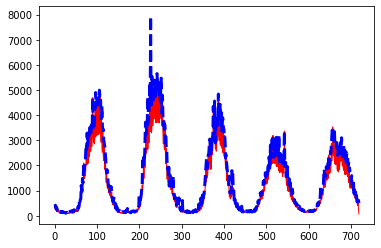

In [59]:
plt.figure()
x_plot =np.arange(0,total_size, 1) 
print(datax['internet'].shape)
plt.plot(x_plot, mean, color='r', linestyle='solid',
     linewidth=1)
plt.plot(x_plot, datax['internet'], color='b', linestyle="--",
     linewidth=3)

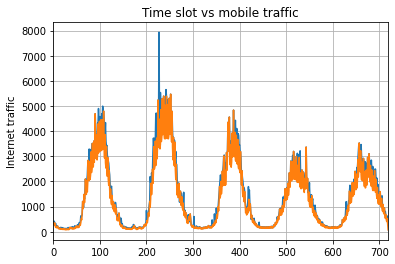

In [60]:
plt.title('Time slot vs mobile traffic')
plt.ylabel('Internet traffic')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(datax['internet'].to_numpy())
plt.plot(x,mean)
plt.show()